In [1]:
from pathlib import Path
from zipfile import ZipFile

dataset_path = Path('dataset')
archive_path = dataset_path / 'digit-recognizer.zip'

sample_path = dataset_path / 'sample_submission.csv'
test_path = dataset_path / 'test.csv'
train_path = dataset_path / 'train.csv'
experiment_dataset_path =  dataset_path / 'experiment_dataset.csv'
control_path = Path('control_test.csv')
sub_path = Path('submission.csv')

if not test_path.exists() or not train_path.exists():
    with ZipFile(archive_path, 'r') as zf:
        zf.extractall(dataset_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import psutil
print(psutil.virtual_memory())

cuda
svmem(total=33979953152, available=11123601408, percent=67.3, used=22856351744, free=11123601408)


In [3]:
class DigitsDataset(Dataset):
    def __init__(self, data, transform=None, train=True):
        self.data = data
        self.transform = transform
        self.train = train
        
        if self.train:
            self.labels = self.data['label'].values
            drop_columns = ['label']
            if any(self.data.columns.str.contains('marker')):
                drop_columns.append('marker')
            self.images_data = self.data.drop(columns=drop_columns).values
        else:
            self.labels = None
            self.images_data = self.data.values
        
        self.images = self.images_data.reshape(-1, 28, 28, 1).astype(np.float32) / 255.0
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        
        if self.transform:
            image = self.transform(image)
            
        if self.train:
            label = self.labels[idx]
            return image, label
        return image

    def show_images(self, indexes: list[int], width = 5, scale = 1):
        imeges_cnt = len(indexes)
        cols = width if imeges_cnt > width else imeges_cnt
        rows = imeges_cnt // cols + 1

        figsize=(scale * cols, scale * rows)
        plt.figure(figsize=figsize)
        for i, idx in enumerate(indexes):
            pixels = self.images_data[idx]
            plt.subplot(rows, cols, i+1)
            plt.imshow(pixels.reshape(28,28), cmap='gray')
            if self.labels is not None:
                plt.title(str(f"id {idx} num {self.labels[idx]}"))
            else:
                plt.title(str(f"id {idx}"))
        plt.tight_layout()
        plt.show()


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def evaluate_model(model, loader, print_class_wise = False):
    model.eval()
    correct = 0
    total = 0
    confusion_matrix = torch.zeros(10, 10)
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
    accuracy_per_class = {}
    
    for target_label in range(10):
        class_correct = confusion_matrix[target_label, target_label].item()  # Правильные предсказания для класса
        class_total = confusion_matrix[:, target_label].sum().item()        # Общий счет по данному классу
        accuracy_per_class[target_label] = round(class_correct/class_total, 4)*100 if class_total != 0 else 0

    if print_class_wise:
        print("\nClass-wise accuracies:")
        for digit, acc in accuracy_per_class.items():
            print(f'Digit {digit}: {acc:.2f}%')
    
    print(f"\nOverall Accuracy: {100 * correct / total:.2f}%")
    return 100 * correct / total


def train_model(train_loader, val_loader, optimizer, criterion, model, epochs=50):
    train_losses = []
    val_accuracies = []
    best_acc = 0.0
    best_epoch = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 200 == 199:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Training Loss: {running_loss / 200:.3f}')
                running_loss = 0.0
                
        # Оцениваем на валидаторе после каждой эпохи
        acc = evaluate_model(model, val_loader)
        val_accuracies.append(acc)
        train_losses.append(running_loss / len(train_loader))
        
        if acc > best_acc:
            best_acc = acc
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')
            
    print(f'\nBest validation accuracy achieved at Epoch {best_epoch}: {best_acc:.2f}%')
    return train_losses, val_accuracies


In [4]:
data = pd.read_csv(train_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
data['label'].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [6]:
df_train = pd.read_csv(train_path)
print("Размер датасета =", len(df_train))


# Выделяем отдельную тестовую выборку из основного файла
test_samples_count = int(df_train.shape[0] * 0.2)
df_test = df_train.sample(n=test_samples_count, random_state=42)
df_train = df_train.drop(df_test.index)

# Train и Validation
train_samples_count = len(df_train) - test_samples_count
df_val = df_train.iloc[train_samples_count:]
df_train = df_train.iloc[:train_samples_count]

print("Размер обучающей выборки =", len(df_train))
print("Размер валидационной выборки =", len(df_val))
print("Размер теста =", len(df_test))

# Создаем наборы данных
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = DigitsDataset(df_train, transform=train_transform, train=True)
val_dataset = DigitsDataset(df_val, transform=test_transform, train=True)
test_dataset = DigitsDataset(df_test, transform=test_transform, train=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Размер датасета = 42000
Размер обучающей выборки = 25200
Размер валидационной выборки = 8400
Размер теста = 8400


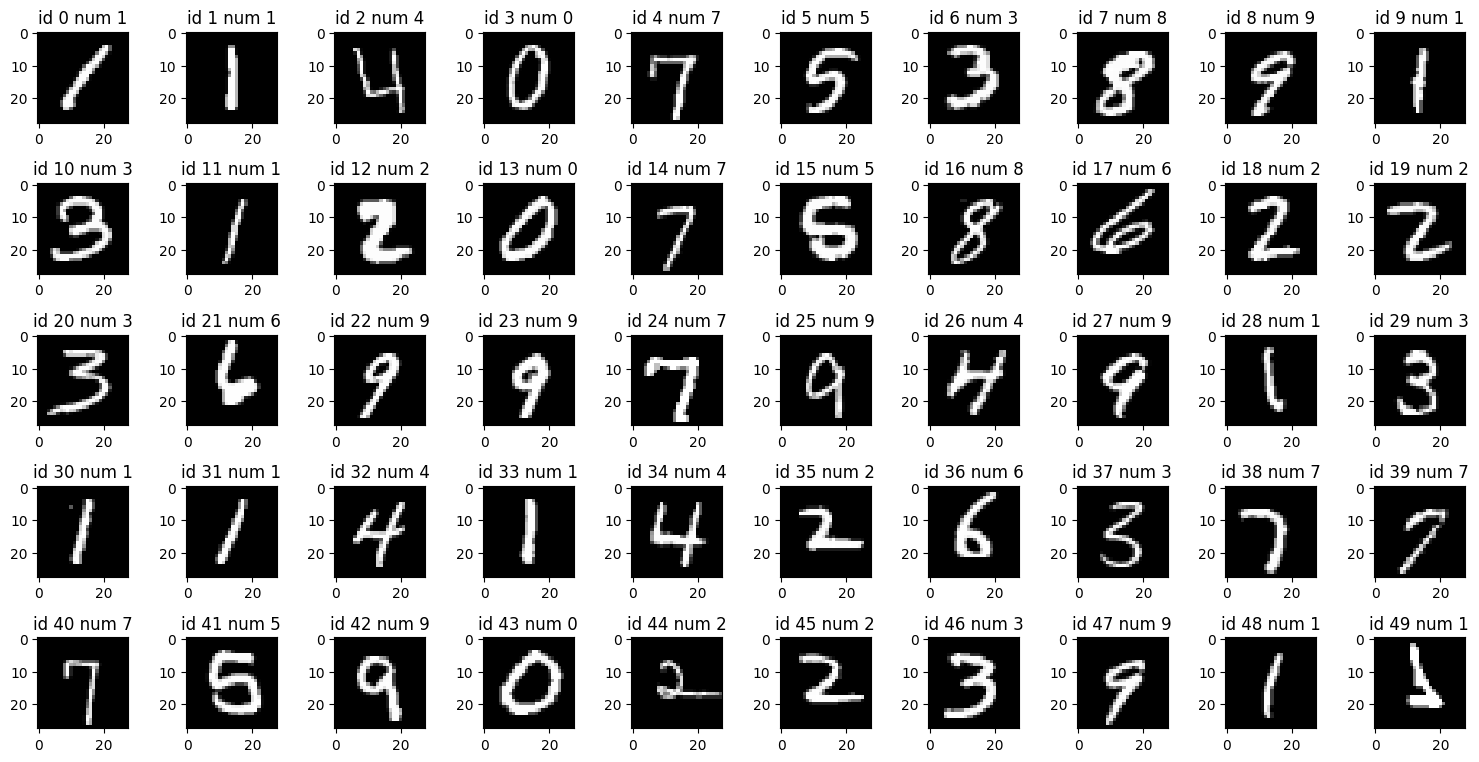

In [7]:
train_dataset.show_images(list(range(0,50)), width = 10, scale = 1.5)

In [8]:
model = SimpleCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 50
train_losses, val_accuracies = train_model(train_loader, val_loader, optimizer, criterion, model, epochs)


Overall Accuracy: 95.49%

Overall Accuracy: 97.35%

Overall Accuracy: 97.90%

Overall Accuracy: 97.89%

Overall Accuracy: 98.43%

Overall Accuracy: 98.43%

Overall Accuracy: 98.30%

Overall Accuracy: 98.45%

Overall Accuracy: 98.68%

Overall Accuracy: 98.73%

Overall Accuracy: 98.75%

Overall Accuracy: 98.93%

Overall Accuracy: 98.70%

Overall Accuracy: 98.61%

Overall Accuracy: 98.77%

Overall Accuracy: 98.82%

Overall Accuracy: 98.83%

Overall Accuracy: 98.70%

Overall Accuracy: 98.95%

Overall Accuracy: 98.95%

Overall Accuracy: 98.92%

Overall Accuracy: 98.79%

Overall Accuracy: 98.88%

Overall Accuracy: 98.83%

Overall Accuracy: 98.98%

Overall Accuracy: 98.93%

Overall Accuracy: 98.94%

Overall Accuracy: 98.88%

Overall Accuracy: 98.93%

Overall Accuracy: 98.88%

Overall Accuracy: 99.01%

Overall Accuracy: 98.93%

Overall Accuracy: 98.88%

Overall Accuracy: 98.75%

Overall Accuracy: 98.81%

Overall Accuracy: 98.76%

Overall Accuracy: 98.85%

Overall Accuracy: 98.99%

Overall Acc

In [10]:
# Загружаем лучшую модель
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, test_loader, print_class_wise=True)


Class-wise accuracies:
Digit 0: 99.63%
Digit 1: 99.56%
Digit 2: 99.52%
Digit 3: 99.36%
Digit 4: 99.04%
Digit 5: 99.13%
Digit 6: 98.49%
Digit 7: 99.11%
Digit 8: 98.81%
Digit 9: 98.81%

Overall Accuracy: 99.15%


99.1547619047619

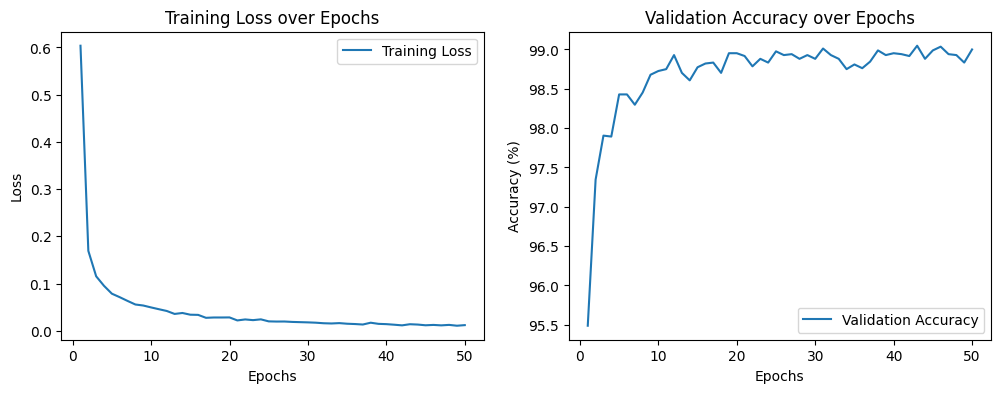

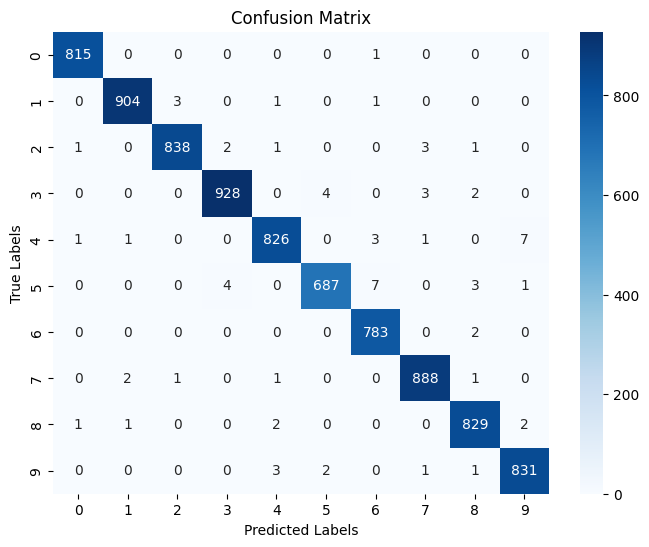

              precision    recall  f1-score   support

           0     0.9963    0.9988    0.9976       816
           1     0.9956    0.9945    0.9950       909
           2     0.9952    0.9905    0.9929       846
           3     0.9936    0.9904    0.9920       937
           4     0.9904    0.9845    0.9874       839
           5     0.9913    0.9786    0.9849       702
           6     0.9849    0.9975    0.9911       785
           7     0.9911    0.9944    0.9927       893
           8     0.9881    0.9928    0.9904       835
           9     0.9881    0.9916    0.9899       838

    accuracy                         0.9915      8400
   macro avg     0.9915    0.9914    0.9914      8400
weighted avg     0.9916    0.9915    0.9915      8400



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import torch

# График обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.show()

# Матрица путаницы
confusion_matrix = torch.zeros(10, 10)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix.numpy().round().astype(int), annot=True, fmt="d", cmap="Blues")  # <--- здесь округляем и приводим к int
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Отчёт по классификации
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

report = metrics.classification_report(y_true, y_pred, digits=4)
print(report)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


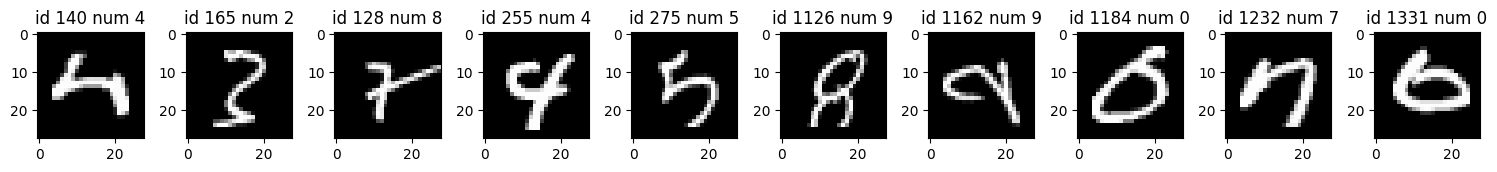

In [12]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions


control_test_df = pd.read_csv(test_path)
display(control_test_df)

control_test_dataset = DigitsDataset(control_test_df, transform=test_transform, train=False)
control_test_loader = DataLoader(control_test_dataset, batch_size=batch_size, shuffle=False)

model.load_state_dict(torch.load('best_model.pth'))
predictions = get_predictions(model, control_test_loader)

control_test_dataset.labels = [int(i) for i in predictions]
control_test_dataset.show_images([140, 165, 128,255,275,1126,1162,1184,1232,1331], width = 10, scale = 1.5)

# Обучение классическими алгоритмами

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Загрузка данных
data = pd.read_csv(train_path)

# Преобразование изображений в плоский массив признаков
features = data.drop(['label'], axis=1)/255.0
labels = data['label']

# Разделение набора данных на тренировки и проверку
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Нормализация входных данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучаем базовые модели
models = {
    'Linear Regression': LinearRegression(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
    'LightGBM Classifier': LGBMClassifier(random_state=42),
    'XGBoost Classifier': XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

for name, clf in models.items():
    try:
        clf.fit(X_train_scaled, y_train)
        predictions = clf.predict(X_test_scaled)
        
        # Метрики для классификации
        report = classification_report(y_test, predictions, output_dict=True)
        conf_matrix = confusion_matrix(y_test, predictions)
        roc_auc = roc_auc_score(pd.get_dummies(y_test), clf.predict_proba(X_test_scaled), multi_class='ovr', average='macro')
        logloss = log_loss(y_test, clf.predict_proba(X_test_scaled))
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        
        print(f'Модель: {name}\nClassification Report:\n{classification_report(y_test, predictions)}\nConfusion Matrix:\n{conf_matrix}\nROC-AUC Score: {roc_auc:.4f}\nLog Loss: {logloss:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\n\n')
    except Exception as e:
        print(f'Ошибка при обучении модели {name}: {e}')

Ошибка при обучении модели Linear Regression: Classification metrics can't handle a mix of multiclass and continuous targets
Модель: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       816
           1       0.95      0.97      0.96       909
           2       0.89      0.86      0.88       846
           3       0.90      0.86      0.88       937
           4       0.91      0.90      0.91       839
           5       0.85      0.86      0.85       702
           6       0.91      0.94      0.92       785
           7       0.93      0.91      0.92       893
           8       0.89      0.88      0.89       835
           9       0.89      0.90      0.89       838

    accuracy                           0.91      8400
   macro avg       0.90      0.91      0.91      8400
weighted avg       0.91      0.91      0.91      8400

Confusion Matrix:
[[777   0   2   2   1  16  14   2   2   0]
 [  

c:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Модель: LightGBM Classifier
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       816
           1       0.99      0.98      0.99       909
           2       0.97      0.97      0.97       846
           3       0.98      0.96      0.97       937
           4       0.97      0.97      0.97       839
           5       0.97      0.96      0.97       702
           6       0.98      0.98      0.98       785
           7       0.98      0.97      0.97       893
           8       0.96      0.98      0.97       835
           9       0.95      0.97      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400

Confusion Matrix:
[[803   0   2   0   3   1   3   0   4   0]
 [  0 894   6   1   1   1   1   2   2   1]
 [  2   3 822   4   5   1   1   2   5   1]
 [  1   2   3 901   1   9   0   5   8   7]


c:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:00:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Модель: XGBoost Classifier
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       816
           1       0.98      0.99      0.99       909
           2       0.97      0.97      0.97       846
           3       0.98      0.96      0.97       937
           4       0.97      0.97      0.97       839
           5       0.97      0.96      0.96       702
           6       0.97      0.99      0.98       785
           7       0.98      0.97      0.97       893
           8       0.97      0.98      0.97       835
           9       0.95      0.97      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400

Confusion Matrix:
[[805   0   1   0   0   0   6   0   3   1]
 [  0 899   4   0   1   1   2   2   0   0]
 [  1   3 824   4   7   1   2   1   3   0]
 [  1   3   5 898   0  12   0   6   5   7]
 

# Experiment

In [14]:
import os
import pandas as pd
import numpy as np
from PIL import Image

if not experiment_dataset_path.exists():
    # Путь к директории с изображениями
    image_dir = 'experiment'

    # Список для хранения всех записей
    records = []

    # Проходим по файлам в директории
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            # Парсим название файла и получаем метку и маркер
            parts = filename.split('_')
            label = int(parts[0])
            marker = parts[1].split('.')[0]
            
            # Открываем изображение и конвертируем в grayscale (чёрно-белый режим)
            img = Image.open(os.path.join(image_dir, filename)).convert('L')
            
            # Флеттенг изображения (преобразовываем двумерную картинку в одномерный список)
            flattened_img = np.array(img).flatten()
            
            # Добавляем запись в список (метка, маркер и пикселы)
            record = {'label': label, 'marker': marker}
            record.update({f'pixel{i}': value for i, value in enumerate(flattened_img)})
            records.append(record)

    # Создание DataFrame
    df = pd.DataFrame(records)

    # Сохранение DataFrame в файл (если нужно)
    df.to_csv(experiment_dataset_path, index=False)

    # Проверка первых строк таблицы
    df.head()

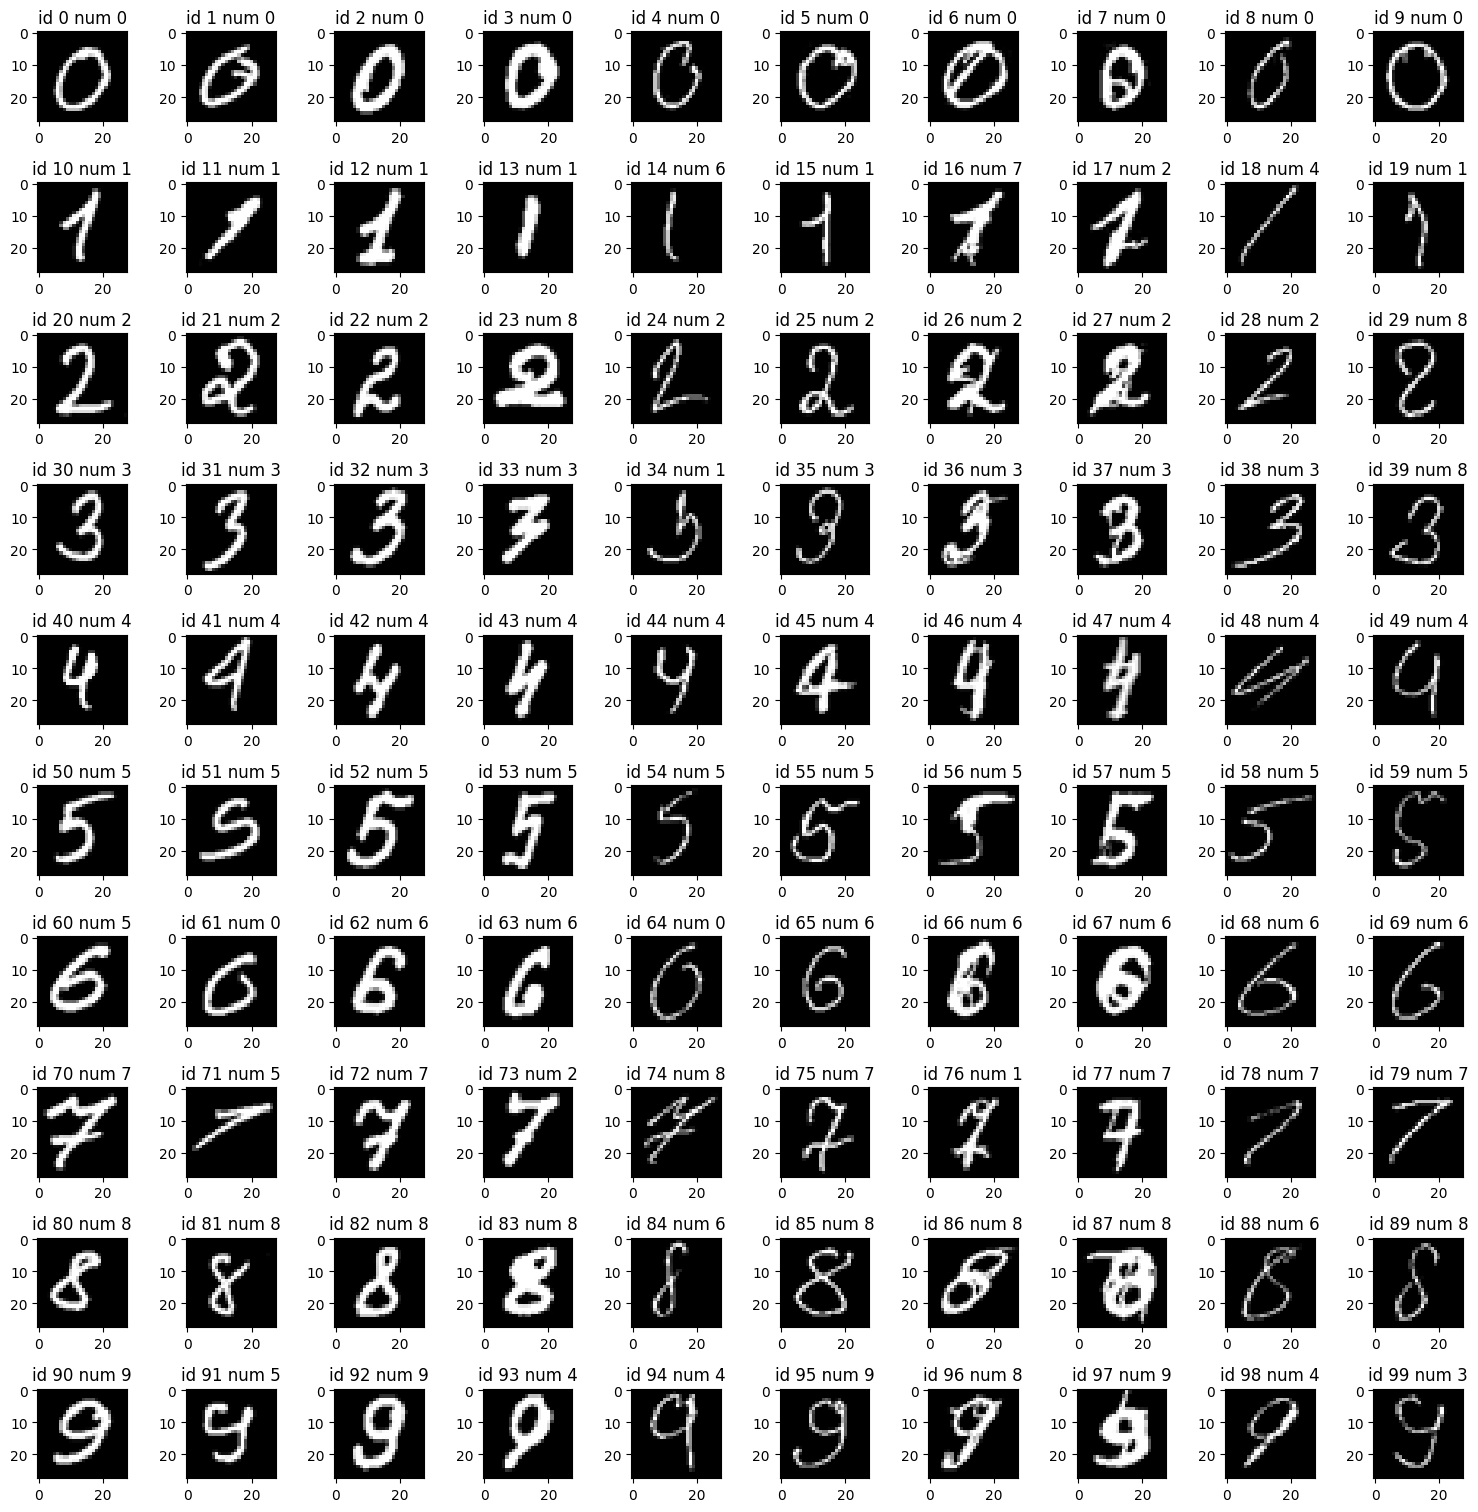

In [15]:
def get_predictions(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

experiment_df = pd.read_csv(experiment_dataset_path)

experiment_test_dataset = DigitsDataset(experiment_df, transform=test_transform, train=True)
experiment_test_loader = DataLoader(experiment_test_dataset, batch_size=batch_size, shuffle=False)

model.load_state_dict(torch.load('best_model.pth'))
predictions = get_predictions(model, experiment_test_loader)

experiment_test_dataset.labels = [int(i) for i in predictions]
experiment_test_dataset.show_images(list(range(0, experiment_df.shape[0])), width = 10, scale = 1.5)